*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [1]:
# Import libraries. You may or may not use all of these.
# !pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers # hint!

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2021-10-04 03:37:28--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.1’

insurance.csv.1     100%[===================>]  49.09K  --.-KB/s    in 0.003s  

2021-10-04 03:37:28 (16.8 MB/s) - ‘insurance.csv.1’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [3]:
dataset.shape

(1338, 7)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
dataset.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [6]:
dataset['age'].describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

In [7]:
dataset['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [8]:
dataset['bmi'].describe()

count    1338.000000
mean       30.665471
std         6.098382
min        16.000000
25%        26.300000
50%        30.400000
75%        34.700000
max        53.100000
Name: bmi, dtype: float64

In [9]:
dataset['children'].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

In [10]:
dataset['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [11]:
dataset['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [12]:
dataset['expenses'].describe()

count     1338.000000
mean     13270.422414
std      12110.011240
min       1121.870000
25%       4740.287500
50%       9382.030000
75%      16639.915000
max      63770.430000
Name: expenses, dtype: float64

In [13]:
# Convert categorical data to numbers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset['sex'] = le.fit_transform(dataset['sex'])
dataset['smoker'] = le.fit_transform(dataset['smoker'])
dataset['region'] = le.fit_transform(dataset['region'])

In [14]:
dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,3,16884.92
1,18,1,33.8,1,0,2,1725.55
2,28,1,33.0,3,0,2,4449.46
3,33,1,22.7,0,0,1,21984.47
4,32,1,28.9,0,0,1,3866.86


In [15]:
# Use 80% of the data as the train_dataset and 20% of the data as the test_dataset
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, train_size=0.8, random_state=42)

In [16]:
train_dataset.shape, test_dataset.shape

((1070, 7), (268, 7))

In [17]:
# pop off the "expenses" column from these datasets 
# to create new datasets called train_labels and test_labels
train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

In [18]:
train_labels.shape, test_labels.shape

((1070,), (268,))

## Linear Regresion with Multiple Variables

In [19]:
# Normalization Layer
from tensorflow.keras.layers.experimental import preprocessing
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_dataset))
print(normalizer.mean.numpy())

[[39.35701     0.5121495  30.562151    1.1074772   0.20560746  1.5084109 ]]


In [20]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [21]:
linear_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 20
Trainable params: 7
Non-trainable params: 13
_________________________________________________________________


In [22]:
linear_model.predict(train_dataset[:10])

array([[-1.4704633 ],
       [-1.5289538 ],
       [-2.766033  ],
       [ 0.57340187],
       [-1.4582901 ],
       [-1.1724416 ],
       [-1.5118806 ],
       [ 3.0140395 ],
       [ 1.5429465 ],
       [ 3.1124766 ]], dtype=float32)

In [23]:
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(6, 1) dtype=float32, numpy=
array([[-0.836566  ],
       [ 0.5700588 ],
       [ 0.4029231 ],
       [ 0.47141683],
       [ 0.75092304],
       [-0.54604614]], dtype=float32)>

In [24]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [25]:
%%time
history = linear_model.fit(
    train_dataset, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 6.14 s, sys: 544 ms, total: 6.69 s
Wall time: 6.13 s


In [26]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,13258.412109,12406.614258,95
96,13255.689453,12404.025391,96
97,13252.952148,12401.410156,97
98,13250.226562,12398.811523,98
99,13247.512695,12396.221680,99


In [27]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 15000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Expenses]')
  plt.legend()
  plt.grid(True)

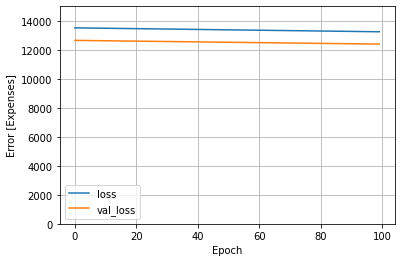

In [28]:
plot_loss(history)

## DNN Regression

In [29]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [30]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                448       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


In [31]:
%%time
history = dnn_model.fit(
    train_dataset, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 7.53 s, sys: 597 ms, total: 8.12 s
Wall time: 10.7 s


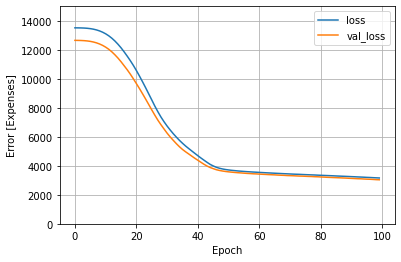

In [32]:
plot_loss(history)

## Final DNN for FCC test

In [33]:
model = keras.Sequential()

model.add(normalizer)
model.add(layers.Dense(128, input_dim=12, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae', 'mse'])

model.fit(
    train_dataset, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6)                 13        
_________________________________________________________________
dense_4 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 13,390
Trainable params: 13,377
Non-trainable params: 13
_________________________________________________________________


9/9 - 0s - loss: 23157142.0000 - mae: 3011.6475 - mse: 23157142.0000
Testing set Mean Abs Error: 3011.65 expenses
You passed the challenge. Great job!


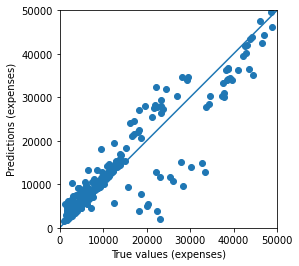

In [34]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
